### Домашнее задание
1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, eta):

    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def residual(y, z):
    return - (z - y)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1060.1647010193176
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5701.895198088998


### Задание1
Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.


#### 1. Зависимость ошибки от числа деревьев

In [11]:
n_trees = [1,5,10,15,20,25]
max_depth = 5
eta = 0.1
train_err = []
test_err = []
for tree in n_trees:
    trees, train_errors, test_errors = gb_fit(tree, max_depth, X_train, X_test, y_train, y_test, eta)
    train_err.append(train_errors[tree-1])
    test_err.append(test_errors[tree-1])

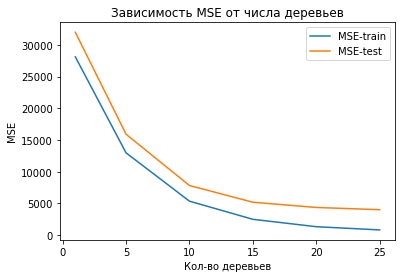

In [12]:

plt.plot(n_trees, train_err, label='MSE-train')
plt.plot(n_trees, test_err, label='MSE-test')
plt.title('Зависимость MSE от числа деревьев')
plt.xlabel('Кол-во деревьев')
plt.ylabel('MSE')
plt.legend()
plt.show()

Вывод: При увеличении числа деревьев в бустниге происходит постепенное уменьшение ошибки как на обучающей так и на тестовой выборках. Эффекта переобучения заметить не удалось. При этом стоит заметить, что использовать больное количество деревьев мало эффективно потому, что график зависимости идёт практически параллельно оси Х и выигрыш по ошибке при этом минимальный. 

#### 2. Зависимость ошибки от максимальной глубины

In [13]:
n_trees = 10
max_depth = np.arange(2,15)
eta = 0.1
train_err = []
test_err = []
for depth in max_depth:
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, eta)
    train_err.append(train_errors[n_trees-2])
    test_err.append(test_errors[n_trees-2])

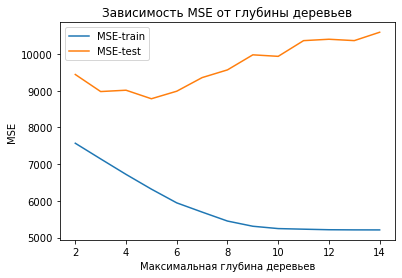

In [14]:
plt.plot(max_depth, train_err, label='MSE-train')
plt.plot(max_depth, test_err, label='MSE-test')
plt.title('Зависимость MSE от глубины деревьев')
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('MSE')
plt.legend()
plt.show()

Вывод: На данном графике явно прослеживается переобучение модели. С ростом глубины мы наблюдаем рост ошибки на тестовой выборке. Поэтому выбор данного параметра нужно производить с осторожностью.

### Задание2
*Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [15]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, size = 0.5):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # ---------------------------------------------------------------------------------------------------------
        # Выбираем случайным образом индыксы из обучающей выборки  и формируем подвыборки для обучения
        # Обучение производим на подготовленной подвыборке, а предсказание на полном "трэйне"
        index_choice = np.random.choice(np.arange(len(X_train)), size=int(size*len(X_train)), replace = False)
        X_train_choice = X_train[index_choice]
        y_train_choice = y_train[index_choice]
        
        #-----------------------------------------------------------------------------------------------------------
        
        
        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_choice, y_train_choice)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_choice, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_choice, residual(y_train_choice, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [16]:
# Число деревьев в ансамбле
n_trees = 20

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1


In [17]:
%%time
trees, MSE_train_sgb, MSE_test_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, size=0.5)

Wall time: 7.08 s


In [18]:
%%time
trees, MSE_train_gb, MSE_test_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 9.06 s


In [19]:
def get_error_plot(n_trees, MSE_train_sgb,MSE_test_sgb, MSE_train_gb, MSE_test_gb, size):

    print(f'Размер подвыборки = {size}')
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.title('Train')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)),  MSE_train_sgb, label='Стохастический gb')
    plt.plot(list(range(n_trees)), MSE_train_gb, label='Классический gb')
    plt.legend(loc='upper right')


    plt.subplot(1,2,2)
    plt.title('Test')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)),  MSE_test_sgb, label='Стохастический gb')
    plt.plot(list(range(n_trees)), MSE_test_gb, label='Классический gb')
    plt.legend(loc='upper right')


plt.show()

Размер подвыборки = 0.5


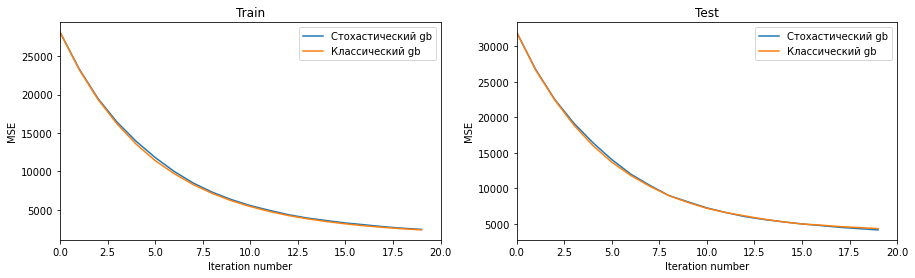

In [20]:
get_error_plot(n_trees, MSE_train_sgb,MSE_test_sgb, MSE_train_gb, MSE_test_gb, 0.5)

In [21]:
%%time
trees, MSE_train_sgb, MSE_test_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, size=0.01)

Wall time: 5.2 s


Размер подвыборки = 0.01


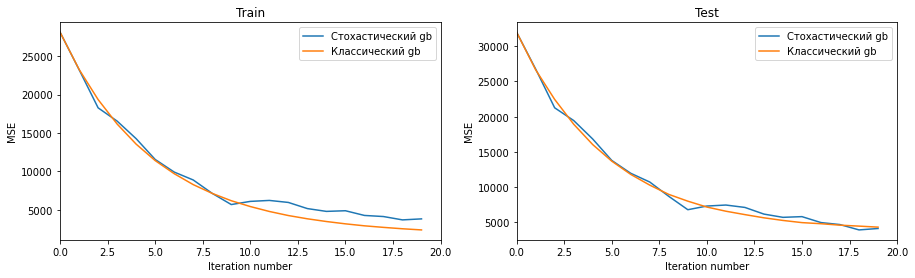

In [22]:
get_error_plot(n_trees, MSE_train_sgb,MSE_test_sgb, MSE_train_gb, MSE_test_gb, 0.01)

### Задание3
3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

In [23]:
def gb_predict_one(X, trees, eta):

    #-----------------------------------------------------------------------------------------------------------------
    # Для предсказаний будем выдавать лишь результаты последнего дерева
    predictions = np.array(
        [eta * trees.predict([x])[0] for x in X]
    )    
    
    
#     print('\n', predictions, 'end\n')
    return predictions

In [24]:
def gb_optim_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    
    #-------------------------------------------------------------------------------------------------------------
    # предсказания будем хранить и добавлять с каждой итерацией, а не делать все предсказания каждый раз
    y_train_predict = np.zeros(X_train.shape[0])
    y_test_predict = np.zeros(X_test.shape[0])
    
    
    #-------------------------------------------------------------------------------------------------------------
    # вынесем предсказание и вычисление ошибка из под if
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
        else:
            # обучаем последующие деревья на предсказаниях
            tree.fit(X_train, residual(y_train, y_train_predict))            


        trees.append(tree)
    
        train_errors.append(mean_squared_error(y_train,  y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))  
     
        y_train_predict += gb_predict_one(X_train, tree, eta)
        y_test_predict += gb_predict_one(X_test, tree, eta)

    return trees, train_errors, test_errors

In [25]:
# Число деревьев в ансамбле
n_trees = 15

# Максимальная глубина деревьев
max_depth = 5

# Шаг
eta = 0.1


Оптимизированный вариант

In [26]:
%%time
trees, MSE_train_optim, MSE_test_optim = gb_optim_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 457 ms


Начальный вариант

In [27]:
%%time
trees, MSE_train_gb, MSE_test_gb = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 5 s


In [28]:
def get_error_plot(n_trees, MSE_train_sgb,MSE_test_sgb, MSE_train_gb, MSE_test_gb):

    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.title('Train')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)),  MSE_train_sgb, label='Оптимизированный gb')
    plt.plot(list(range(n_trees)), MSE_train_gb, label='Начальный gb')
    plt.legend(loc='upper right')


    plt.subplot(1,2,2)
    plt.title('Test')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)),  MSE_test_sgb, label='Оптимизированный gb')
    plt.plot(list(range(n_trees)), MSE_test_gb, label='Начальный gb')
    plt.legend(loc='upper right')


plt.show()

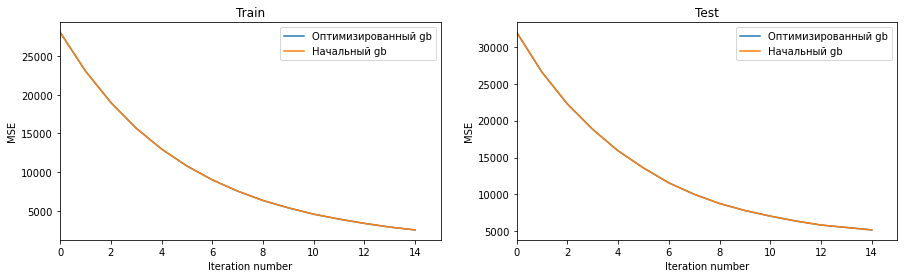

In [29]:
get_error_plot(n_trees, MSE_train_optim, MSE_test_optim, MSE_train_gb, MSE_test_gb)

Графики полностью совпадают - следовательно оптимизированный вариант работает идентично начальному

Есть небольшое размышление по поводу корректности работы функции gb_fit приведённой в методичке. 
  

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
        
после того как мы обучили первое дерево мы подсчитываем MSE для этого мы передаём в **gb_predict(X_train, trees, eta)** список деревьев **_trees_**, но на данном этапе **_trees_** пуст так как **_trees.append(tree)_** мы сделаем только в конце цикла. Таким образом **gb_predict(X_train, trees, eta)** выдаст пустой список и список ошибок у нас на первой итерации заполняется нулями. 
